#### Prepared by: Yerbol Aussat
#### CS-889. University of Waterloo



# Real-Time Finger Tracking

# Helper Functions

In [39]:
# Import necessary libraries and helper functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from helpers import imshow

In [40]:
# Method that generates mask that segments out skin regions 
def segment_skin_hsv(img):
    # Convert image to HSV
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # define range of hsv (for skin color)
    min_HSV = np.array([0, 58, 30], dtype = "uint8")
    max_HSV = np.array([33, 255, 255], dtype = "uint8")

    # create a mask and clean it up
    mask = cv2.inRange(hsv, min_HSV, max_HSV)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, None, iterations = 5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, None, iterations = 5)
    mask = cv2.medianBlur(mask, 5)   
    
    return mask

In [44]:
def segment_skin_ycrcb(img):
    # Convert image to YCrCb
    imageYCrCb = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)    
    
    # Constants for finding range of skin color in YCrCb
    min_YCrCb = np.array([0,133,77],np.uint8)
    max_YCrCb = np.array([255,173,127],np.uint8)

    # Find region with skin tone in YCrCb image
    mask = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, None, iterations = 5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, None, iterations = 3)
    mask = cv2.medianBlur(mask, 5)   
    
    return mask

In [45]:
def getHandContours(mask):
    # Get the contour of the hand and draw it on the original image
    im2, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Calculate areas
    areas = [cv2.contourArea(cont) for cont in contours]
    
    # Only keep the largest contour
    if len(contours) == 0:
        return
    cnt = contours[np.argmax(areas)]
    return cnt

In [72]:
# Helper function to find angle between two vectors
def get_angle(v1, v2):
    v1 = v1 / np.linalg.norm(v1) # unit vector v1
    v2 = v2 / np.linalg.norm(v2) # unit vector v2
    cos_theta = np.dot(v1, v2) 
    return np.arccos(cos_theta)*(180/np.pi)

# Helper function to find distance between two vectors
def dist(v1, v2):
    return np.linalg.norm(np.array(v1)-v2)

In [116]:
# # Helper function that updates an array of stored points, corresponding to 
# # valleys or peaks)
# pointDict: {index -> k_curv}

def update(pointDict, j, kCurv, samplePoints):
    
    for i in pointDict:
        
        # if index j is close to one of the stored indices 
        if abs(i-j) <= 10 or abs(i-j) >= len(samplePoints) - 10:
            
            # if k-curvature of point j is smaller, replace i by it
            if kCurv < pointDict[i]:
                pointDict[j] = kCurv
                del pointDict[i]
            return pointDict                        
    pointDict[j] = kCurv
    return pointDict

In [117]:
def getPeaksAndValleys(samplePoints, thresh_angle, k):
    peaks = {} # Dictionary that stores points corresponding to fingertips
    valleys = {} # Dictionary that stores points corresponding to spaces

    for j in range(len(samplePoints)):

        # determine points corresponding to indices j-k, j and j+k
        jCoord = samplePoints[j][0]
        minusK = samplePoints[(j-k)%len(samplePoints)][0]
        plusK = samplePoints[(j+k)%len(samplePoints)][0]

        kCurv = get_angle(minusK - jCoord, plusK - jCoord)

        if kCurv <= thresh_angle:

            orientation = np.cross(minusK - jCoord, plusK - jCoord)

            if orientation >= 0:
                peaks = update(peaks, j, kCurv, samplePoints)
            else:
                valleys = update(valleys, j, kCurv, samplePoints)
    return peaks, valleys

# Real-Time Finger Tracking Code

No contours found


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arccos
  


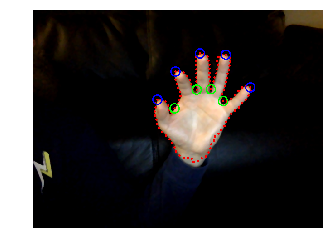

In [127]:
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 

# k-curvature parameters:
k = 5
thresh_angle = 70


while True:
    # Get frame and flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)

    frame = cv2.medianBlur(frame,5) # Apply median blur
    mask = segment_skin_ycrcb(frame) # Get mask
    cv2.imshow("MASK", mask)
    cnt = getHandContours(mask) # Hand Contour
    
    # If contour is None or too small, continue
    if cnt is None or len(cnt) <= 300:
        print "No contours found"
        continue
    
    # Get sample points
    interval = len(cnt)/100
    sample_points = cnt[0:len(cnt):interval]    
    
    # Draw sample points
    for i in range(len(sample_points)):
        cv2.circle(frame, tuple(sample_points[i][0]), 1, (0, 0, 255), 2) 
    
    # Get and draw peaks and valleys
    peaks, valleys = getPeaksAndValleys(sample_points, thresh_angle, k)
    
    for i in peaks:
        cv2.circle(frame, tuple(sample_points[i][0]), 10, (255, 0, 0), 2)         
    for i in valleys:
        cv2.circle(frame, tuple(sample_points[i][0]), 10, (0, 255, 0), 2)
        
    if cv2.waitKey(5) == 27:
        break 
    elif cv2.waitKey(5) == 32:
        cv2.imwrite("saved_frame.jpg", frame) 
        imshow(frame)
    
    cv2.imshow("VideoFrame", frame)

cv2.destroyAllWindows()
camera.release()


# Real-Time Finger and Hand Tracking

In [128]:
# Method that returns maximum inscribed circle
def get_palm_circle(contour, mask):
    dist_max = np.zeros((mask.shape[0], mask.shape[1]))
    for y in range(0, mask.shape[0], 4):
        for x in range(0, mask.shape[1], 4):
            if mask[y, x]:
                dist_max[y, x] = cv2.pointPolygonTest(contour, (x, y), True)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dist_max)
    return max_loc, max_val

In [ ]:
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 

# k-curvature parameters:
k = 5
thresh_angle = 70


while True:
    # Get frame and flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)

    frame = cv2.medianBlur(frame,5) # Apply median blur
    mask = segment_skin_ycrcb(frame) # Get mask
    cv2.imshow("MASK", mask)
    cnt = getHandContours(mask) # Hand Contour
    
    # If contour is None or too small, continue
    if cnt is None or len(cnt) <= 300:
        print "No contours found"
        continue
    
    # Draw palm
    palm_center, palm_radius = get_palm_circle(cnt, mask)
    cv2.circle(frame, palm_center, int(palm_radius), (0,255,255), 3)
    cv2.circle(frame, palm_center, 1, (0,255,255), 6)
    
    # Get sample points
    interval = len(cnt)/100
    sample_points = cnt[0:len(cnt):interval]    
    
    # Draw sample points
    for i in range(len(sample_points)):
        cv2.circle(frame, tuple(sample_points[i][0]), 1, (0, 0, 255), 2) 
    
    # Get and draw peaks and valleys
    peaks, valleys = getPeaksAndValleys(sample_points, thresh_angle, k)
    
    for i in peaks:
        cv2.circle(frame, tuple(sample_points[i][0]), 10, (255, 0, 0), 2) 
        drawFingerOrientation(frame, sample_points, k, i, palm_radius)
    
        
    if cv2.waitKey(5) == 27:
        break 
    elif cv2.waitKey(5) == 32:
        cv2.imwrite("saved_frame.jpg", frame) 
        imshow(frame)
    
    cv2.imshow("VideoFrame", frame)

cv2.destroyAllWindows()
camera.release()


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arccos
  


In [ ]:
def drawFingerOrientation(frame, samplePoints, k, j, palm_radius):                
    
    # get a midpoint between C(i-k) and C(i+k)
    jCoord = samplePoints[j][0]
    plusK = samplePoints[(j + k)%len(samplePoints)][0]
    minusK = samplePoints[(j - k)%len(samplePoints)][0]    
    mid_finger = np.mean([minusK, plusK], axis=0).astype(int)
    
    orientation = np.cross([100, 0], mid_finger - jCoord) # whether cross product points up or down
    angle = np.sign(orientation) * get_angle([100, 0],  mid_finger - jCoord)*3.14/180.0
        
    # Point 1
    x1 = sample_points[i%len(sample_points)][0][0] + palm_radius * np.cos(angle)
    y1 = sample_points[i%len(sample_points)][0][1] + palm_radius * np.sin(angle)
    point1 = [int(x1), int(y1)]

    # Point 2
    x2 = sample_points[i%len(sample_points)][0][0] - 3*palm_radius * np.cos(angle)
    y2 = sample_points[i%len(sample_points)][0][1] - 3*palm_radius * np.sin(angle)
    point2 = [int(x2), int(y2)]    
    
    cv2.line(frame, tuple(point1), tuple(point2), (255, 255, 255), 3)